# ACML Homework: Convolutional Autoencoders
by Jonathan Ächtner and Thomas Bahne

# Data preperation and utilities

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, List

In [9]:
def load_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """downloads the cifar10 data set and divides it into a training, validation, and test set

  Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray]: Train, Validation, Test set
  """ 
  (X_1, y_1), (X_2, y_2) = tf.keras.datasets.cifar10.load_data()
  X = np.vstack((X_1, X_2))
  y = np.vstack((y_1, y_2))
  X_train, X, y_train, y = train_test_split(X, y, train_size=0.8, stratify=y)
  X_test, X_valid, _, _  = train_test_split(X, y, test_size=0.5, stratify=y)
  return X_train, X_valid, X_test

def prepare_images(img: np.ndarray, gray=False) -> np.ndarray:
  """Normalizes and (optinally) grayscales images

  Args:
      img (np.ndarray): Array of images, given in RGB-pixel values
      gray (bool, optional): Set to true will grayscale the images. Defaults to False.

  Returns:
      np.ndarray: Normalized and (optinally) grayscaled array of images
  """  
  img = img/255
  img_s1, img_s2, img_s3, img_s4 = img.shape
  if gray:
    to_grayscale = lambda x: x[:,:,:,0] * 0.299 + x[:,:,:,1] * 0.5870 + x[:,:,:,2] * 0.1140
    img_gray = to_grayscale(img)
    img = img
    return img_gray.reshape((img_s1, img_s2, img_s3, 1))
  else:
    return img.reshape(img.shape)

def load_prepare() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  """Downloads the CIFAR10 data set, normalizes and graysclaes the images

  Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Normalized Train, Validation and Test sets for color and grayscaled images
  """  
  X_train_new, X_valid_new, X_test_new = load_data()

  X_train = prepare_images(X_train_new)
  X_valid = prepare_images(X_valid_new)
  X_test = prepare_images(X_test_new)

  X_train_bw = prepare_images(X_train_new, True)
  X_test_bw = prepare_images(X_test_new, True)
  X_valid_bw = prepare_images(X_valid_new, True)

  return X_train, X_valid, X_test, X_train_bw, X_valid_bw, X_test_bw

def save_model(model, path = 'models/CAE') -> None:
  model.save(path)

def load_model(path = 'models/CAE') -> None:
    return keras.models.load_model(path)

def img_compare(img_org: np.ndarray, img_pred: np.ndarray, cmap: str='gray') -> None:
  """Plots the original image next to the output of the Autoencoder

  Args:
      img_org (np.ndarray): Original version of the image
      img_pred (np.ndarray): Output of the auto encoder for the image
      cmap (str, optional): [description]. Defaults to 'gray'.
  """  
  plt.subplot(221).imshow(img_org)
  plt.subplot(221).set_title(f'original img: {img_org.shape}')
  if img_pred.shape == (32,32,1):
    img_pred = img_pred.reshape((32,32))
    plt.subplot(222).imshow(img_pred, cmap=cmap)
    plt.subplot(222).set_title(f'predict img: {img_pred.shape}')
  else:
    plt.subplot(222).imshow(img_pred)
    plt.subplot(222).set_title(f'predict img: {img_pred.shape}')
  plt.show()

def model_fit_transform(model, x_train, y_train=None, x_valid=None, y_valid=None, x_test=None, y_test=None, step_size=1e-3, epochs=10):
  model.summary()
  """Fits the model on training data, if available evaluates it on the validation set

  Args:
      model (keras.Sequential): model to be trained
      x_train (np.ndarray): training inputs
      y_train (np.ndarray): labels of training inputs ()

  Returns:
      Tuple[keras.Sequential, np.ndarray, np.ndarray, np.ndarray]: fitted model, output of the model for training-, validation-, and test instances, history of training
  """
  if x_valid.any() != None:
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=1)
  else:
    history = model.fit(x_train, y_train, epochs=epochs, verbose=1)

  predictions_x_train = model.predict(x_train, verbose=1)

  if x_valid.any() != None:
    predictions_x_valid = model.predict(x_valid, verbose=1)

  if x_test.any() != None:
    predictions_x_test = model.predict(x_test, verbose=1)

  
  return model, predictions_x_train, predictions_x_valid, predictions_x_test, history

## 1. Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data.

In [10]:
X_train, X_valid, X_test, X_train_bw, X_valid_bw, X_test_bw = load_prepare()

shape_color_instance = X_train[0].shape
shape_bw_instance = X_train_bw[0].shape

## 2. Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the evolution of the error with epochs. Report also the test error.

In [11]:
epochs = 10

def plot_acc_err(epochs, model, history):
  # Plot accuracy and report test error
  plt.figure()
  plt.plot(range(1, epochs+1), history.history['loss'], '-', label='Training loss')
  plt.plot(range(1, epochs+1), history.history['val_loss'], '--', label='Validation loss')
  plt.title(f'Training and validation loss')
  plt.legend()
  plt.show()

  print(f'Test set loss: {model.evaluate(X_test, X_test, verbose=1)[0]}')

In [5]:
# build the model
def create_model(input_shape):
  model =  Sequential()
  model.add(Input(shape=input_shape))
  model.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2), padding='same'))
  model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
  model.add(UpSampling2D())
  model.add(Conv2D(3, kernel_size=(3,3), padding='same', activation='relu'))
  return model

models: List[keras.Sequential] = [create_model(shape_color_instance), create_model(shape_color_instance), create_model(shape_color_instance), create_model(shape_color_instance)]
learning_rates: List[float] = [1e-5, 1e-3, 0.1]

# compile multiple models to test different learning rates and loss functions
for index, model in enumerate(models):
  if index < 3:
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rates[index]),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryCrossentropy()])
  else:
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[keras.metrics.MeanSquaredError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 12)        1

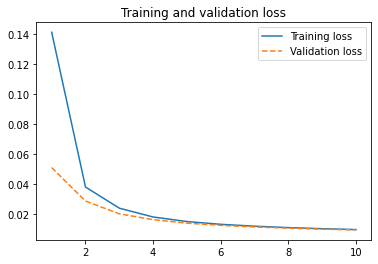

188/188 [==============================] - 1s 5ms/step - loss: 0.0093 - binary_crossentropy: 0.5778
Test set loss: 0.009319012053310871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


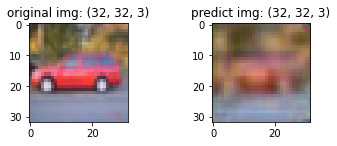

In [20]:
model, _, _, test_prediction, history = model_fit_transform(models[0], X_train, X_train, X_valid, X_valid, X_test, X_test, epochs=epochs)
plot_acc_err(epochs, model, history)
img_compare(X_test[0], test_prediction[0], cmap='viridis')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 12)       

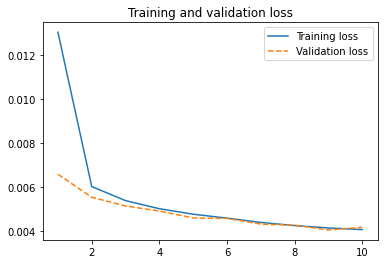

188/188 [==============================] - 1s 5ms/step - loss: 0.0042 - binary_crossentropy: 0.5614
Test set loss: 0.00417210441082716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


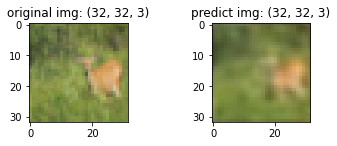

In [10]:
model, _, _, test_prediction, history = model_fit_transform(models[1], X_train, X_train, X_valid, X_valid, X_test, X_test, epochs=epochs)
plot_acc_err(epochs, model, history)
img_compare(X_test[0], test_prediction[0], cmap='viridis')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 12)       

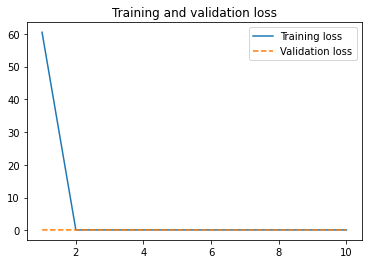

188/188 [==============================] - 1s 5ms/step - loss: 0.1424 - binary_crossentropy: 2.9504
Test set loss: 0.14241576194763184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


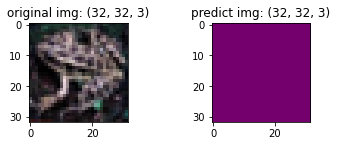

In [7]:
model, _, _, test_prediction, history = model_fit_transform(models[2], X_train, X_train, X_valid, X_valid, X_test, X_test, epochs=epochs)
plot_acc_err(epochs, model, history)
img_compare(X_test[0], test_prediction[0], cmap='viridis')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 12)       

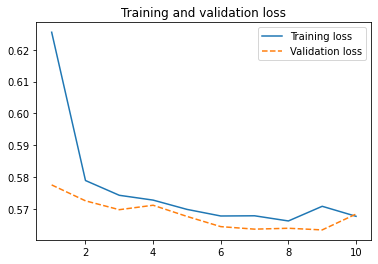

188/188 [==============================] - 1s 5ms/step - loss: 0.5674 - mean_squared_error: 0.0082
Test set loss: 0.567424476146698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


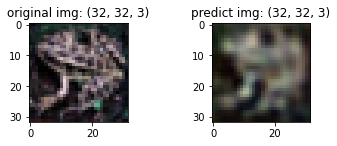

In [6]:
model, _, _, test_prediction, history = model_fit_transform(models[3], X_train, X_train, X_valid, X_valid, X_test, X_test, epochs=epochs)
plot_acc_err(epochs, model, history)
img_compare(X_test[0], test_prediction[0], cmap='viridis')

We see that for a learning rate of 1e-5 it takes longer than 10 epochs for the model to converge. A learning rate of 0.1 seems to high, the model produces way higher loss values compared to models that use smaller learning rates (and basically outputs an image with only one color). A learning rate of 1e-3 seems to be a good trade-off between training time and quality of the results. Overall however, the images are quite blurry. Using binary cross entropy versus mean squared error does not seem to have an impact.

## 1. What is the size of the latent space representation of the above network?

These following are the numbers for the variables of the last convultion layer (i.e. the latent space)

Input volume = 8 (8x8)\
Kernel size = 3 (3x3)\
Padding = 1\
Stride = 1\
Channels = 16

Size of latent space = $(\frac{8-3+2\cdot 1}{1}+1)^2\cdot 16$ = 1024

## 2. Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and padding configurations) to answer questions such as: What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

### 2.1 drastically increasing number of channels

In [13]:
model_layout01 = Sequential()
model_layout01.add(Input(shape=shape_color_instance))
model_layout01.add(Conv2D(128, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout01.add(Conv2D(92, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout01.add(MaxPooling2D(pool_size = (2,2)))
model_layout01.add(Conv2D(78, kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(MaxPooling2D(pool_size = (2,2)))
model_layout01.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))

model_layout01.add(UpSampling2D(size=(2,2)))
model_layout01.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_layout01.add(UpSampling2D())
model_layout01.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_layout01.add(Conv2D(3,(3,3), padding='same', activation='relu'))

model_layout01.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])


In [19]:
model_layout01, X_train_1, X_valid_1, X_test_1, history = model_fit_transform(model_layout01, x_train=X_train, y_train=X_train, x_valid=X_valid, y_valid=X_valid, x_test=X_test, y_test=X_test, epochs=10)
img_compare(X_test[1], X_test_1[1], cmap='viridis')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 92)        106076    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 92)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 78)        64662     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 78)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          44992     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 16, 16, 64)       

ValueError: ignored

We see that performance increases dramatically, especially when visually comparing the two pictures. This is somewhat expected, as we are increasing the size of our latent space by increasing the number of channels. Looking at the formula to calculate the size of the latent space, our latent space is 4x as large, as we have 4x as many channels and channels multiply the size. With a larger latent space, the information does not need to be condensed as much, which results in a better ability of our model to reconstruct the image, as it has more information than previously.

### Adding more Max-Pooling Layers

In [ ]:
model_layout02 = Sequential()
model_layout02.add(Input(shape=shape_color_instance))
model_layout02.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model_layout02.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2)))
model_layout02.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(MaxPooling2D(pool_size = (2,2)))
model_layout02.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D(size=(2,2)))
model_layout02.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D())
model_layout02.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_layout02.add(UpSampling2D())
model_layout02.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_layout02
model_layout02.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryCrossentropy()])

In [ ]:
model_layout02, X_train_2, X_valid_2, X_test_2 = model_fit_transform(model_layout02, X_train, X_valid, X_test)

In [ ]:
img_compare(X_test[1], X_test_2[1])

We see that by reducing the input volume of the latent space, we see a decrease in performance. The information in the image needs to be compressed even more than before to fit the size of the latent space and inevitably, this leads to some loss of information. This in turn, leads to a decreasde in performance of our model.

### Attempt to increase sharpness by adding more convolutional layers in the decoder

In [ ]:
model_layout03 = Sequential()
model_layout03.add(Input(shape=shape_color_instance))
model_layout03.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model_layout03.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(MaxPooling2D(pool_size = (2,2)))
model_layout03.add(Conv2D(128, kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(UpSampling2D(size=(2,2)))
model_layout03.add(Conv2D(64,kernel_size = (3,3), padding='same', activation='relu'))
model_layout03.add(UpSampling2D())
model_layout03.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu'))
model_layout03.add(Conv2D(3,(3,3), padding='same', activation='sigmoid'))


# compile the model_layout03
model_layout03.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])


In [ ]:
model_layout03, X_train_3, X_valid_3, X_test_3 = model_fit_transform(model_layout03, X_train, X_valid, X_test)
img_compare(X_test[0], X_test_3[0])

For this particular architecture, we see an increase in performance compared to the model with more Max-Pooling layers (which is to be expected as the latent space of this model is larger), but it is still outperformed by the network with more channels. Therefore we can say that adding more convolutional layers for the decoder does not contribute towards better performance.

### Drastically reducing model complexity

In [ ]:
model_layout04 = Sequential()
model_layout04.add(Input(shape=shape_color_instance))
model_layout04.add(Conv2D(3, kernel_size = (3,3), padding='same',  activation='relu'))


model_layout04.compile(
  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
  loss=keras.losses.MeanSquaredError(),
  metrics=[keras.metrics.BinaryCrossentropy()])

In [ ]:
model_layout04, X_train_4, X_valid_4, X_test_4 = model_fit_transform(model_layout04, X_train, X_valid, X_test)
img_compare(X_test[1], X_test_4[1])

This experiment is quite interesting, as this model only has one layer. In theory, it should therefore learn to not change the image at all. Presumably, the filters the network learns only have the individual pixels contribute to the output of that same pixel.

### Trying a different stride parameter

To still have the model output the same dimension as the input, we remove some layers and increase the upsampling factors of the upsampling layers.

In [ ]:
model_layout05 =  Sequential()
model_layout05.add(Input(shape=shape_color_instance))
model_layout05.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu', strides=(2, 2)))
model_layout05.add(MaxPooling2D(pool_size = (2,2), padding='same'))
model_layout05.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu', strides=(2, 2)))
model_layout05.add(UpSampling2D(size=(4,4)))
model_layout05.add(Conv2D(3,(3,3), padding='same', activation='relu', strides=(2, 2)))
model_layout05.add(UpSampling2D(size=(4,4)))

model_layout05.compile(
  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
  loss=keras.losses.MeanSquaredError(),
  metrics=[keras.metrics.BinaryCrossentropy()])

In [ ]:
model_layout05, X_train_5, X_valid_5, X_test_5 = model_fit_transform(model_layout05, X_train, X_valid, X_test)
img_compare(X_test[1], X_test_5[1])

## 1. Adapt your network from the previous part such that it learns to reconstruct colors

In [ ]:
img_compare(X_train[0], X_train_bw[0])

In [ ]:
# build the model_bw

model_bw = Sequential()
model_bw.add(Input(shape=X_train_bw[0].shape))
model_bw.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(Conv2D(12, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(6,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(1,(3,3), padding='same', activation='relu'))


# compile the model_bw
model_bw.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_bw.summary()

In [ ]:
# learn model for bw representation

history_bw = model_bw.fit(X_train_bw, X_train_bw, epochs=10, validation_data=(X_valid_bw, X_valid_bw), verbose=1, use_multiprocessing=True)

In [ ]:
# evaluate bw model
model_bw.evaluate(X_test_bw, X_test_bw)

In [ ]:
predictions_bw = model_bw.predict(X_train_bw, verbose=1)

In [ ]:
predictions_bw.shape
X_train_comb = np.concatenate((predictions, predictions_bw),3)

In [ ]:
# build model_comb for combination of prediction model_comb

model_comb = Sequential()
model_comb.add(Input(shape=X_train_comb[0].shape))
model_comb.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D(size=(2,2)))
model_comb.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D())
model_comb.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_comb
model_comb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_comb.summary()

In [ ]:
history_comb = model_comb.fit(X_train_comb, X_train, epochs=7, verbose=1, use_multiprocessing=True)

In [ ]:
predict_comb = model_comb.predict()

def comp_comb_org(comb_img, org_img):
    plt.subplot(221).imshow(org_img)
    plt.subplot(221).set_title(f'original img: {org_img.shape}')
    plt.subplot(222).imshow(comb_img)
    plt.subplot(222).set_title(f'predict img: {comb_img.shape}')
    plt.show()


In [ ]:
img_compare(X_train[0], predict_comb[0])

In [ ]:
save_model(model_comb, 'models/model_pipe_comb')
save_model(model_bw, 'models/model_pipe_bw')

### try model_test for recolorization

In [ ]:
model_test = Sequential()
# model_test.add(Input(shape=X_train_bw.shape))
model_test.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu', input_shape=(32,32,1)))
# model_test.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
# model_test.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
# model_test.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(64,kernel_size = (3,3), padding='same', activation='relu'))
# model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))

model_test.add(UpSampling2D())
model_test.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(UpSampling2D())

model_test.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(3,(3,3), padding='same', activation='sigmoid'))


model_test.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])
model_test.summary()


In [ ]:
print(X_train_bw.shape, X_train.shape)

model_test.fit(X_train_bw, X_train, validation_data=(X_valid_bw, X_valid), epochs=10, verbose=1)
predictions_test_recol = model_test.predict(X_test_bw, verbose=1)

In [ ]:
img_compare(X_test[1], predictions_test_recol[1])

### try 4 models for color channels/grayscales dimensions and one for combination.

In [ ]:
small_model_color = Sequential()
small_model_color.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(64, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(16, (3,3), padding='same', activation='relu'))
small_model_color.add(Conv2D(1, (3,3), padding='same', activation='sigmoid'))


small_model_color.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])

In [ ]:
small_model_r, X_train_r, X_valid_r, X_test_r = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,0], X_valid_bw, X_valid[:,:,:,0], X_test_bw, X_test[:,:,:,0])
small_model_g, X_train_g, X_valid_g, X_test_g = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,1], X_valid_bw, X_valid[:,:,:,1], X_test_bw, X_test[:,:,:,1])
small_model_b, X_train_b, X_valid_b, X_test_b = model_fit_transform(small_model_color, X_train_bw, X_train[:,:,:,2], X_valid_bw, X_valid[:,:,:,2], X_test_bw, X_test[:,:,:,2])
small_model_gray, X_train_gray, X_valid_gray, X_test_gray = model_fit_transform(small_model_color, X_train_bw, X_train_bw, X_valid_bw, X_valid_bw, X_test_bw, X_test_bw)

In [ ]:
X_train_colstack = np.stack((X_train_r, X_train_g, X_train_b, X_train_gray), 3).reshape((48000,32,32,4))
X_valid_colstack = np.stack((X_valid_r, X_valid_g, X_valid_b, X_valid_gray), 3).reshape((6000,32,32,4))
X_test_colstack = np.stack((X_test_r, X_test_g, X_valid_b, X_valid_gray), 3).reshape((6000,32,32,4))


In [ ]:
model_comb_recol = Sequential()
model_comb_recol.add(Input(shape=X_train_colstack[0].shape))
model_comb_recol.add(Conv2D(128, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb_recol.add(Conv2D(92, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb_recol.add(MaxPooling2D(pool_size = (2,2)))
model_comb_recol.add(Conv2D(78, kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(MaxPooling2D(pool_size = (2,2)))
model_comb_recol.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))

model_comb_recol.add(UpSampling2D(size=(2,2)))
model_comb_recol.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_comb_recol.add(UpSampling2D())
model_comb_recol.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_comb_recol.add(Conv2D(3,(3,3), padding='same', activation='relu'))

model_comb_recol.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_col_comb, X_train_col_comb, X_valid_col_comb, X_test_col_comb = model_fit_transform(model_comb_recol, X_train_colstack, X_train, X_valid_colstack, X_valid, X_test_colstack, X_test)

In [ ]:
img_compare(X_test[0], X_test_col_comb[0])